# NLP Disaster Tweets Mini-Project

#### CSCA 5642: Week 4: NLP Disaster Tweets Kaggle Mini-Project

&nbsp;

<b>Instructions</b>: <i>This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP).

The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others’ submissions.</i>

First, I'll import the libraries I need for this project.

In [62]:
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, LSTM, Dense, SimpleRNN, Dropout, LeakyReLU, GRU

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

Then, I'll import the data needed for the project.

In [2]:
# This is our folder with all of the data
data_path = "/kaggle/input/nlp-getting-started"
print("Files in dataset folder:", os.listdir(data_path), '\n')

# Import the CSV
data = pd.read_csv(f'{data_path}/train.csv')
print(data.head())

Files in dataset folder: ['sample_submission.csv', 'train.csv', 'test.csv'] 

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


### Brief description of the problem and data (5 pts)

<b>Instructions</b>: <i>Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.</i>

In this Kaggle challenge, I'll attempt to create a deep learning model that can categorize tweets into two groups: disaster-related and non-disaster-related. Social media platforms like Twitter are increasingly providing information about what's happening around the world, and there is interest in tracking this information. A machine learning algorithm can help in that task.

Let's take a look at the size and shape of the data.

In [3]:
data.shape

(7613, 5)

We have 7,613 tweets to work with, and five attributes. The attributes are id, keyword, location, text, and target. Let's explore them.

The id attribute provides a unqiue identifier for each tweet.

In [4]:
data['id']

0           1
1           4
2           5
3           6
4           7
        ...  
7608    10869
7609    10870
7610    10871
7611    10872
7612    10873
Name: id, Length: 7613, dtype: int64

Just to double check that each value is unique:

In [5]:
sum(data['id'].value_counts().values > 1)

0

There's also a keyword column. What kind of values are in there?

In [6]:
data['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

Those keywords could be helpful! What kinds of locations are attached to these tweets?

In [7]:
data['location'].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

That location data could be helpful information as well, good to know!

We also have a text column with the text from the tweet. What does an example tweet look like?

In [8]:
# Randomly choose a tweet to read
data.sample(1)['text'].iloc[0]

'her loyalty mission involves her kicking a shitty nobleman to death???? I love this elven weirdo'

There's quite a variety of tweets in this dataset.

We also have a target column, which has 1 for tweets that are about real disasters, and 0 for tweets that are not. Those are the only values in this column:

In [9]:
data['target'].unique()

array([1, 0])

### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

<b>Instructions</b>: <i>Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?</i>

Let's check for missing values and decide if we need to clean them up in any way.

In [10]:
missing_percent = data.isnull().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)
print(missing_percent)

location    33.272035
keyword      0.801261
id           0.000000
text         0.000000
target       0.000000
dtype: float64


Looks like the id, text, and target columns don't have any missing values. About 0.8% of tweets don't have any keywords, and about one third of tweets don't have a location. I anticipate the most important columns in this dataset being the text and target columns, so it's good that they don't have any missing values. I'll leave the other missing values alone for now.

Next, I'm wondering if the dataset is balanced between the two target classes. Let's look:

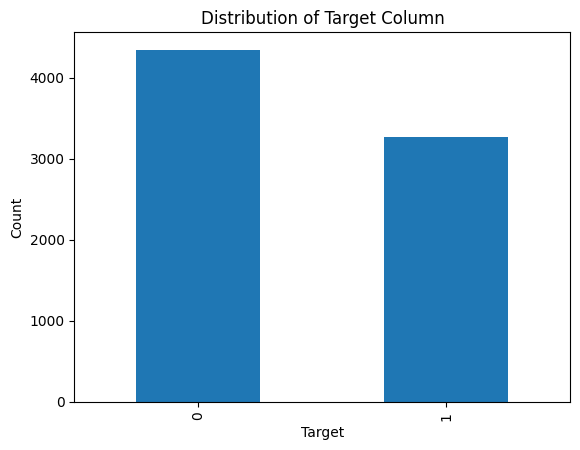

In [11]:
data['target'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Column')
plt.show()

In [12]:
print(data['target'].describe())

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64


It looks like we have slightly more non-diaster tweets than disaster tweets in the dataset. A mean of 0.43 in a column of only 0s and 1s means we have about 43% zeroes, and the remaining 57% are ones.

The submission to the competition will be graded on F1 score, not accuracy, so I'll want to pay attention to precision and recall when building and evaluating models. The fact that these two classes are somewhat equally represented in the dataset is helpful.

I'm also wondering if keywords are helpful in identifying the target class. I counted up which keywords had the highest association with class 1 tweets (disaster tweets). Here are the results:

In [13]:
keyword_target_counts = data.groupby(['keyword', 'target']).size().unstack(fill_value=0)
keyword_target_counts['total'] = keyword_target_counts[0] + keyword_target_counts[1]
keyword_target_counts['disaster_ratio'] = keyword_target_counts[1] / keyword_target_counts['total']
best_indicators = keyword_target_counts.sort_values(by=['disaster_ratio', 'total'], ascending=False)
print(best_indicators.head(10))

target             0   1  total  disaster_ratio
keyword                                        
derailment         0  39     39        1.000000
wreckage           0  39     39        1.000000
debris             0  37     37        1.000000
outbreak           1  39     40        0.975000
oil%20spill        1  37     38        0.973684
typhoon            1  37     38        0.973684
suicide%20bombing  1  32     33        0.969697
suicide%20bomber   1  30     31        0.967742
bombing            2  27     29        0.931034
rescuers           3  32     35        0.914286


These keywords make sense as being closely related to tweets about disasters. Note that "%20" in a keyword indicates a space character.

Are there keywords that are closely related to non-disaster tweets as well? Here's a look at the other end of the list:

In [14]:
print(best_indicators.tail(10))

target        0  1  total  disaster_ratio
keyword                                  
blew%20up    31  2     33        0.060606
panicking    31  2     33        0.060606
traumatised  33  2     35        0.057143
screaming    34  2     36        0.055556
electrocute  31  1     32        0.031250
body%20bag   32  1     33        0.030303
blazing      33  1     34        0.029412
ruin         36  1     37        0.027027
body%20bags  40  1     41        0.024390
aftershock   34  0     34        0.000000


These keywords could also be associated with disasters, but they also have uses in contexts other than disasters, so they don't appear to be good indicators of disaster tweets.

I also want to see how long these tweets are. Here's the distrbution of number of characters in a tweet:

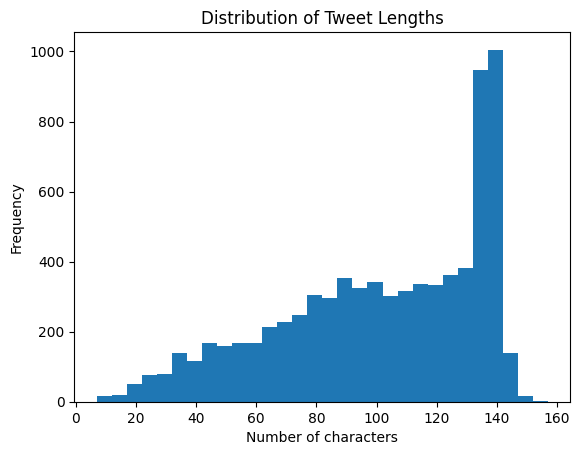

In [15]:
plt.hist(data['text'].str.len(), bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.show()

We see that frequency increases as number of characters increases, with a clear maximum in the 130-145 character range, and then a steep dropoff. Tweets at this time were limited to a certain number of characters, which would explain the steep dropoff.

Since this project requires us to work with text, I'll be using techniques from natural language processing (NLP) to help train the neural network. NLP is a specific area of data science that is tailored towards training machine learning models with text.

One of the first data cleaning tasks in NLP is to make all of the characters lowercase. Uppercase letters introduce what is often unnecessary complexity for the model, since uppercase and lowercase letters will be treated as different characters. To make things simpler for our model, I'll make all of the letters lowercase.

In [16]:
# Here's a tweet with some capital letters
data['text'][345]

'Well done Celtic Fingers crossed for Aberdeen tomorrow night! \nArmageddon eh.... ??'

In [17]:
# Now, I'll turn all letters in the column to lowercase.
data['text'] = data['text'].str.lower()

In [18]:
# All of the letters in this tweet should be lowercase now
data['text'][345]

'well done celtic fingers crossed for aberdeen tomorrow night! \narmageddon eh.... ??'

I also need to remove URLs from the text, since those are not going to be helpful to the model in most cases, and they would be additional words it needs to learn.

In [19]:
# Here's a tweet with a URL in it
data[data['id'] == 48]['text'].iloc[0]

'@bbcmtd wholesale markets ablaze http://t.co/lhyxeohy6c'

In [20]:
# This regex expression finds URLs and removes them
data['text'] = data['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)

In [21]:
# The URL from our example is now gone
data[data['id'] == 48]['text'].iloc[0]

'@bbcmtd wholesale markets ablaze '

On Twitter, you can mention other users in a tweet by using at at symbol in front of their username in your tweet. Those usernames probably aren't going to be very useful for determining whether a tweet is about a disaster or not (in the majority of cases). Therefore, I'll remove those.

In [22]:
# Text from a tweet that mentions @bbcmtd
data[data['id'] == 48]['text'].iloc[0]

'@bbcmtd wholesale markets ablaze '

In [23]:
data['text'] = data['text'].str.replace(r'@\w+', '', regex=True)

In [24]:
# Now the username has been removed from the text
data[data['id'] == 48]['text'].iloc[0]

' wholesale markets ablaze '

If there's any HTML tags in the dataset, those should be removed too. Let's see if that is the case:

In [25]:
data[data['text'].str.contains(r'<[^>]+>', regex=True, na=False)]

,id,keyword,location,text,target


There aren't any HTML tags in these tweets, so I don't need to remove any.

Now, I'll remove punctuation and special characters. Once again, this is so that the model pick them (or the words their attached to) up and learn them as separated words. They aren't meaningful enough to warrant the additional dimensionality they would introduce to the model.

In [26]:
# An example tweet with several punctuation and special characters
data.iloc[4209]['text']

"our tipster previews chelsea v swansea &amp; there's a 48/1 double!  \n#chelsea #hazard "

In [27]:
data['text'] = (
    data['text']
    .str.replace(r'&\w+;', '', regex=True)       # Remove HTML entities like &amp;
    .str.replace(r'\\\w+', '', regex=True)       # Remove \n, \u1234, etc.
    .str.replace(r'[^\w\s]', '', regex=True)     # Remove punctuation and special characters
)

In [28]:
# The punctuation and special characters are gone
data.iloc[4209]['text']

'our tipster previews chelsea v swansea  theres a 481 double  \nchelsea hazard '

Let's also remove numbers from the text as well.

In [29]:
data['text'] = data['text'].str.replace(r'\d+', '', regex=True)

In [30]:
# The numbers are now gone from this tweet as well
data.iloc[4209]['text']

'our tipster previews chelsea v swansea  theres a  double  \nchelsea hazard '

Lastly, let's take care of any place that has too many whitespaces.

In [31]:
data['text'] = (
    data['text']
    .str.strip()                                 # Remove whitespace from both ends of the string
    .str.replace(r'\s+', ' ', regex=True)        # Normalize whitespace within the string
)

In [32]:
# No more double space characters in between words
data.iloc[4209]['text']

'our tipster previews chelsea v swansea theres a double chelsea hazard'

Now, I'll remove stopwords. In NLP, stopwords are articles, prepositions, and other parts of English that provide additional understanding for humans, but since they aren't keywords, they won't be very useful for the model, so it's best to remove them.

I'm going to use the NLTK package to get a list of stopwords, and then remove those words from all tweets.

In [33]:
# An example tweet with stopwords like 'just', 'in', 'a', 'on', ...
data.iloc[3245]['text']

'just got engulfed in a carinduced tidal wave on my run i thought this only happened in the movies'

In [34]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# Stopwords are gone, and we're left with mostly keywords
data.iloc[3245]['text']

'got engulfed carinduced tidal wave run thought happened movies'

Lastly, before I wrap up data cleaning and move on to model building, I want to stem the words. Stemming takes the various forms of words and reduces them to their root. For example, "runs", "running", and "runner" would be reduced to "run". The stem of each word is most important to it's meaning, so this technique makes model training simpler.

I'll implement the Porter Stemmer to perform this task, a common choice for stemming in NLP.

In [36]:
# An example tweet with some words that can be stemmed
data.iloc[3872]['text']

'maryland mansion fire killed caused damaged plug christmas tree report says flames'

In [37]:
stemmer = PorterStemmer()
data['text'] = data['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [38]:
# Words have been reduced to their stems where possible with Porter Stemmer
data.iloc[3872]['text']

'maryland mansion fire kill caus damag plug christma tree report say flame'

### Model Architecture (25 pts)

<b>Instructions</b>: <i>Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).</i>

Before building deep learning models, the text data needs to be in the correct format. In the previous section, we cleaned up the data, and now we'll put them in a format the model can learn.

I'll use a tokenizer from Keras to turn words into a corresponding integer. To see how many tokens will be created, I'll find out how many unique words there are across all tweets:

In [39]:
all_words = ' '.join(data['text']).split()
len(set(all_words))

11866

Looks like there's 11,866 words, but some of those are probably uncommon words that the model won't learn well. I'll have the tokenizer turn the most common 10,000 words into integers, the rest will all be assigned the same token ("--uncommon--") which will be turned into a integer as well.

In [40]:
tokenizer = Tokenizer(num_words=10000, oov_token="--uncommon--")
tokenizer.fit_on_texts(data['text'])

We can see the tweets turned into integers by getting sequences from the tokenizer:

In [41]:
sequences = tokenizer.texts_to_sequences(data['text'])

In [42]:
print(data['text'][1])
print(sequences[1])

forest fire near la rong sask canada
[142, 3, 190, 497, 5165, 5166, 1042]


Machine learning models generally expect inputs to be rectnagular. Right now, all of our tweets have different lengths. I'll have the sequences padded with zeroes on the end so we end up with a rectangular matrix of tweets.

What is the longest tweet in the dataset?

In [43]:
len(max(sequences, key=len))

23

The longest tweet is 23 tokens. In case there is a slightly longer tweet in the testing set, I'll pad the tweets to a length of 25 tokens.

In [44]:
padded = pad_sequences(sequences, maxlen=25, padding='post')

In [45]:
padded

array([[3661,  463,  212, ...,    0,    0,    0],
       [ 142,    3,  190, ...,    0,    0,    0],
       [1366,  498, 1844, ...,    0,    0,    0],
       ...,
       [3442,  461, 1355, ...,    0,    0,    0],
       [  30,  168, 2671, ...,    0,    0,    0],
       [ 171,   31,  427, ...,    0,    0,    0]], dtype=int32)

In [46]:
padded.shape

(7613, 25)

The padded matrix has 7,613 tweets and 25 columns, where each column can hold one token from the tweet.

Lastly, before model training, I'll split the data into 80% for training and 20% for validation.

In [47]:
X_train, X_val, y_train, y_val = train_test_split(
    padded, data['target'],
    test_size=0.2,
    stratify=data['target'],
    random_state=1
)

The first model I want to try is a simple artificial neural network (ANN). I realize this isn't a architecture typically used for NLP tasks, and there are others out there better suited for it. However, I think this will provide a baseline from which to compare other models, like LSTMs, later on.

The first later is an Embedding layer, which takes the sequence of tokens (words represented as integers) and turns each token into a vector with length `output_dim`. This is then flattened and they become inputs to a dense layer of 128 neurons, which then feed into a single neuron that makes the prediction.

In [48]:
simple_ann = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00003)

# Compile the model
simple_ann.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
simple_ann_results = simple_ann.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-21 12:49:48.652191: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5114 - loss: 0.6909 - val_accuracy: 0.5706 - val_loss: 0.6785
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5734 - loss: 0.6767 - val_accuracy: 0.5706 - val_loss: 0.6740
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5660 - loss: 0.6733 - val_accuracy: 0.5706 - val_loss: 0.6691
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5719 - loss: 0.6650 - val_accuracy: 0.5890 - val_loss: 0.6630
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6034 - loss: 0.6541 - val_accuracy: 0.6461 - val_loss: 0.6541
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6933 - loss: 0.6438 - val_accuracy: 0.6540 - val_loss: 0.6420
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7222 - loss: 0.6210 - val_accuracy: 0.7019 - val_loss: 0.6265
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7661 - loss: 0.6014 - val_accuracy: 0.7229 - val_

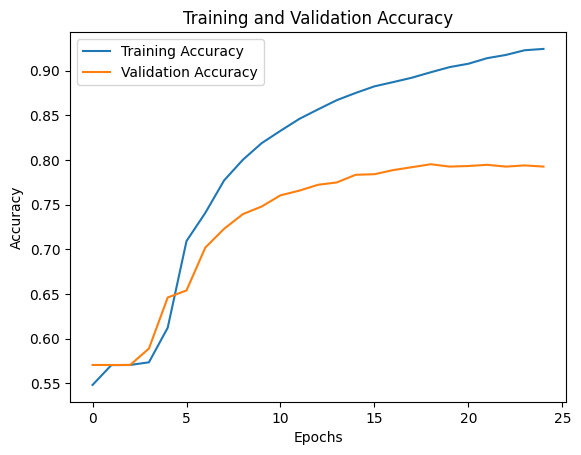

In [49]:
plt.plot(simple_ann_results.history['accuracy'], label='Training Accuracy')
plt.plot(simple_ann_results.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

The training for this model looks really stable, and the accuracy on the validation set is around 0.75 to 0.80. I performed some hyperparamter tuning, specifically on the learning rate, in order to get the training to become this stable. I found a learning rate of 0.00003 worked well for this model. From the plot above, it looks like we don't see much meaningful improvement after 15 epochs, so I'll limit this neural network to 15 epochs to help avoid overfitting. Limiting epochs is another example of hyperparameter tuning.

In [50]:
simple_ann = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00003)

# Compile the model
simple_ann.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
simple_ann_start = time.time()
simple_ann_results = simple_ann.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val)
)
simple_ann_end = time.time()

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5748 - loss: 0.6848 - val_accuracy: 0.5706 - val_loss: 0.6779
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5698 - loss: 0.6769 - val_accuracy: 0.5706 - val_loss: 0.6738
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5742 - loss: 0.6694 - val_accuracy: 0.5712 - val_loss: 0.6690
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5816 - loss: 0.6611 - val_accuracy: 0.5811 - val_loss: 0.6626
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6051 - loss: 0.6545 - val_accuracy: 0.6152 - val_loss: 0.6535
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6509 - loss: 0.6394 - val_accuracy: 0.6691 - val_loss: 0.6418
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7254 - loss: 0.6272 - val_accuracy: 0.6809 - val_loss: 0.6277
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7541 - loss: 0.5963 - val_accuracy: 0.

In this week's lectures, we learning about recurrent neural networks (RNNs) for working with sequential data. Words in a tweet are an example of sequential data, so I'm curious if using an RNN architecture could enhance accuracy for this task.

In [51]:
simple_rnn = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=25),
    SimpleRNN(128),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00003)

# Compile the model
simple_rnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
simple_rnn_start = time.time()
simple_rnn_results = simple_rnn.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val)
)
simple_rnn_end = time.time()

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5614 - loss: 0.6799 - val_accuracy: 0.6028 - val_loss: 0.6642
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6446 - loss: 0.6261 - val_accuracy: 0.6697 - val_loss: 0.6106
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7270 - loss: 0.5438 - val_accuracy: 0.7190 - val_loss: 0.5681
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7952 - loss: 0.4626 - val_accuracy: 0.7354 - val_loss: 0.5428
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8273 - loss: 0.4065 - val_accuracy: 0.7564 - val_loss: 0.5405


I created a simple recurrent neural network, just the embedding layer with a layer of 128 RNN cells, which then feed into a single neuron providing output. However, this model didn't seem to do much better than the regular, simple artificial neural network I created before. I kept the learning rate at 0.00003 and training remained stable. I want to note that the RNN converged faster than the artificial neural network. I limited training to 5 epochs since that is about how long it takes to converge. However, the accuracy is about the same, maybe slightly worse than the artificial neural network.

We learned in the lectures this week that vanilla RNNs like this one can struggle with learning long-term patterns and context, so it makes sense why this model didn't perform much better than the simple artificial neural network.

In order to solve this problem, I want to introduce Long-Short Term Memory (LSTM) and see if that improves the model. LSTM maintains a hidden state that helps the model leverage long-term patterns and context to make better predictions, which is ideal for training on sequences of text.

In [52]:
simple_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=25),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00003)

# Compile the model
simple_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
simple_lstm_start = time.time()
simple_lstm_results = simple_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)
simple_lstm_end = time.time()

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5410 - loss: 0.6911 - val_accuracy: 0.5706 - val_loss: 0.6838
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5805 - loss: 0.6810 - val_accuracy: 0.5706 - val_loss: 0.6796
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5746 - loss: 0.6770 - val_accuracy: 0.5706 - val_loss: 0.6616
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6444 - loss: 0.6101 - val_accuracy: 0.7820 - val_loss: 0.5080
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7995 - loss: 0.4375 - val_accuracy: 0.7886 - val_loss: 0.4734
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8303 - loss: 0.3916 - val_accuracy: 0.7899 - val_loss: 0.4687
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8577 - loss: 0.3507 - val_accuracy: 0.7919 - val_loss: 0.4700
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8681 - loss: 0.3228 - val_ac

I got roughly the same accuracy on the validation set using an LSTM layer as I did with the simple artificial neural network I created earlier. However, it looks like the LSTM converged faster, while also increasing accruacy at a stable rate each epoch (e.g. the accuracy does not bounce around wildly from epoch to epoch). Therefore, I tuned the epoch parameter and set it to 10 to avoid overfitting. The existing learning rate of 0.00003 seems to be working well.

Maybe I can enhance model accuracy further by adding some more layers. This time, I'll try an additional LSTM layer, plus a dense layer to help process the output from the LSTM layer before the model makes a prediction.

In [53]:
multiple_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=25),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00003)

# Compile the model
multiple_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
multiple_lstm_start = time.time()
multiple_lstm_results = multiple_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)
multiple_lstm_end = time.time()

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.5262 - loss: 0.6924 - val_accuracy: 0.5706 - val_loss: 0.6881
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5631 - loss: 0.6868 - val_accuracy: 0.5706 - val_loss: 0.6779
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5795 - loss: 0.6743 - val_accuracy: 0.5706 - val_loss: 0.6702
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5732 - loss: 0.6622 - val_accuracy: 0.6566 - val_loss: 0.6087
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7572 - loss: 0.5481 - val_accuracy: 0.7820 - val_loss: 0.5015
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8434 - loss: 0.4092 - val_accuracy: 0.7827 - val_loss: 0.4812
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8494 - loss: 0.3698 - val_accuracy: 0.7846 - val_loss: 0.4846
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8687 - loss: 0.3340 - val_acc

Doesn't look like that changed much. The accuracy is about the same as it was with just a single LSTM layer, and it converges just about as quickly too.

I wonder if adding a dropout layer would help? A dropout layer basically disconnects random neurons so that the model cannot rely on them. Dropout forces the network to build stronger connections with other neurons to compensate for the randomly disconnected neurons. As we discussed in the lecture, this helps prevent overfitting. Let's see if it improves accuracy here as well.

In [54]:
dropout_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=25),
    LSTM(64, dropout=0.5, return_sequences=True),
    LSTM(32, dropout=0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00003)

# Compile the model
dropout_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
dropout_lstm_start = time.time()
dropout_lstm_results = dropout_lstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)
dropout_lstm_end = time.time()

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5008 - loss: 0.6937 - val_accuracy: 0.5706 - val_loss: 0.6914
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5374 - loss: 0.6913 - val_accuracy: 0.5706 - val_loss: 0.6883
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5626 - loss: 0.6891 - val_accuracy: 0.5706 - val_loss: 0.6853
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5626 - loss: 0.6867 - val_accuracy: 0.5706 - val_loss: 0.6828
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5648 - loss: 0.6863 - val_accuracy: 0.5706 - val_loss: 0.6815
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5644 - loss: 0.6854 - val_accuracy: 0.5706 - val_loss: 0.6802
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5647 - loss: 0.6851 - val_accuracy: 0.5706 - val_loss: 0.6791
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5796 - loss: 0.6774 - val_acc

The dropout layer certainly had an effect on how quickly the model learned. The first eight or nine epochs plateaued, before the accuracy on the validation set jumped up to 0.75 to 0.8. This is the best model, but not my much, so I'll try to iterate further on this.

In the previous model, I used 0.5 for the dropout layer. That means half of the neurons were randomly disconnected. That can be a lot of neurons to lose, so maybe a smaller number of neurons to drop would work better. I'll try tuning this hyperparameter to 0.2 instead and see if there's any improvement.

In [55]:
less_dropout_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=25),
    LSTM(64, dropout=0.2, return_sequences=True),
    LSTM(32, dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00003)

# Compile the model
less_dropout_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
less_dropout_lstm_start = time.time()
less_dropout_lstm_results = less_dropout_lstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)
less_dropout_lstm_end = time.time()

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.5343 - loss: 0.6924 - val_accuracy: 0.5706 - val_loss: 0.6889
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5718 - loss: 0.6879 - val_accuracy: 0.5706 - val_loss: 0.6835
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5680 - loss: 0.6835 - val_accuracy: 0.5706 - val_loss: 0.6796
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5680 - loss: 0.6815 - val_accuracy: 0.5706 - val_loss: 0.6765
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5716 - loss: 0.6771 - val_accuracy: 0.5706 - val_loss: 0.6672
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5735 - loss: 0.6583 - val_accuracy: 0.7400 - val_loss: 0.5723
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7943 - loss: 0.5190 - val_accuracy: 0.7768 - val_loss: 0.4947
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8305 - loss: 0.4218 - val_acc

It looks like lowering the amount of neurons to drop made the model slightly worse, so 0.5 is a better selection for the dropout layer's hyperparameter.

We also discussed Leaky ReLU in the lectures this week. Leaky ReLU is a variation of the Rectified Linear Unit (ReLU) acitvation function. Regular ReLU makes negative inputs to the function go to zero, and leaves positive inputs as they are. However, making neurons output zero for a negative number might not always be helpful, so Leaky ReLU assigns a small negative value instead of zero. Those negative values are determined by the negative_slope hyperparamter. Based on my research, a negative_slope of 0.01 is common.

I implemented a Leaky ReLU activation function after the dense layer in the model, and we'll see if it improves the accuracy of the model on the validation set.

In [56]:
leaky_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=25),
    LSTM(64, dropout=0.5, return_sequences=True),
    LSTM(32, dropout=0.5),
    Dense(32),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00003)

# Compile the model
leaky_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
leaky_lstm_start = time.time()
leaky_lstm_results = leaky_lstm.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val)
)
leaky_lstm_end = time.time()

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4704 - loss: 0.6944 - val_accuracy: 0.5706 - val_loss: 0.6915
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5355 - loss: 0.6914 - val_accuracy: 0.5706 - val_loss: 0.6887
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5641 - loss: 0.6881 - val_accuracy: 0.5706 - val_loss: 0.6856
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5742 - loss: 0.6852 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5672 - loss: 0.6855 - val_accuracy: 0.5706 - val_loss: 0.6819
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5768 - loss: 0.6813 - val_accuracy: 0.5706 - val_loss: 0.6804
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5805 - loss: 0.6793 - val_accuracy: 0.5706 - val_loss: 0.6781
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5686 - loss: 0.6805 - val_acc

The model seemed to converge around the 15th epoch, so I stopped the model there, and got a good accuracy, but it's still not the best model here. It looks like the Leaky ReLU didn't have much effect in this case. I tried other common values for the negative_slope, like 0.2 and 0.3, but didn't see much difference there either.

With that, I've created a number of models, many of which performed similarly well, and in the following section, I'll review and discuss the findings.

### Results and Analysis (35 pts)

<b>Instructions</b>: <i>Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.</i>

In [57]:
model_summary = pd.DataFrame()
model_summary['Model'] = ['Simple Artificial NN', 'Recurrent NN', 'RNN w/ Single LSTM Layer', 'RNN w/ Multiple LSTM Layers',
                          'RNN w/ LSTM and 50% Dropout Layers', 'RNN w/ LSTM and 20% Dropout Layers', 'RNN w/ LSTM, Dropout, and LeakyReLU']
model_summary['Accuracy'] = [simple_ann_results.history['val_accuracy'][-1],
                             simple_rnn_results.history['val_accuracy'][-1],
                             simple_lstm_results.history['val_accuracy'][-1],
                             multiple_lstm_results.history['val_accuracy'][-1],
                             dropout_lstm_results.history['val_accuracy'][-1],
                             less_dropout_lstm_results.history['val_accuracy'][-1],
                             leaky_lstm_results.history['val_accuracy'][-1],]
model_summary['Training Time (sec)'] = [simple_ann_end - simple_ann_start,
                                        simple_rnn_end - simple_rnn_start,
                                        simple_lstm_end - simple_lstm_start,
                                        multiple_lstm_end - multiple_lstm_start,
                                        dropout_lstm_end - dropout_lstm_start,
                                        less_dropout_lstm_end - less_dropout_lstm_start,
                                        leaky_lstm_end - leaky_lstm_start,]
model_summary['Epochs'] = [15, 5, 10, 10, 20, 20, 15]
model_summary['Training Time per Epoch (sec)'] = model_summary['Training Time (sec)'] / model_summary['Epochs']
model_summary

,Model,Accuracy,Training Time (sec),Epochs,Training Time per Epoch (sec)
0,Simple Artificial NN,0.780039,17.605865,15,1.173724
1,Recurrent NN,0.756402,14.978990,5,2.995798
2,RNN w/ Single LSTM Layer,0.796454,67.866507,10,6.786651
3,RNN w/ Multiple LSTM Layers,0.794485,58.513693,10,5.851369
4,RNN w/ LSTM and 50% Dropout Layers,0.799737,116.186018,20,5.809301
5,RNN w/ LSTM and 20% Dropout Layers,0.784636,118.440027,20,5.922001
6,"RNN w/ LSTM, Dropout, and LeakyReLU",0.792515,85.672068,15,5.711471


The table above provides a summary of the performance of the models I built. All had an accuracy between 0.75 and 0.8, which is good, but there's certainly room for improvement.

Throughout the model building process, I tried many different archtectures, including RNNs, LSTMs, dropout, LeakyReLU, and more. I also tuned hyperparameters for these models, specifically for the learning rate, numver of epochs, dropout layer amounts, and negative slope for LeakyReLU.

The model with the best accuracy was the RNN with multiple LSTM layers and several 50% dropout layers. It had an accuracy on the validation dataset that was around 80%. Since this was the best model, let's take a closer look at the confusion matrix for this model's predictions on the validation dataset.

In [60]:
y_pred_probs = dropout_lstm.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
cm = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.80      0.71      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



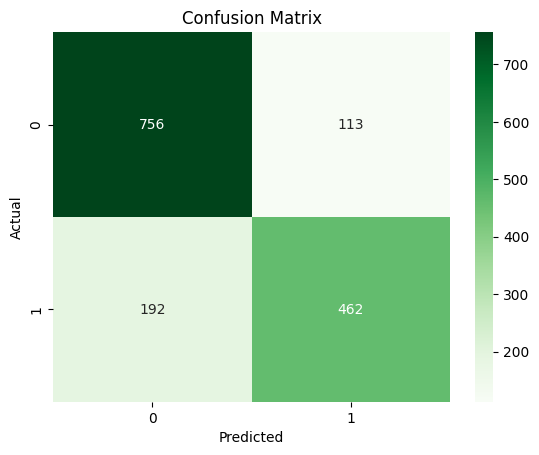

In [63]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Looking at the confusion matrix and some of the metrics on the performance of the model, an accuracy of 0.8 looks to be representative of the model's predictions. We know from the data exploration earlier that the dataset is somewhat unbalanced, with more non-disaster tweets than disaster tweets. When the dataset is unbalanced, we know that accuracy can sometimes be a misleading figure. However, the misclassifications from this model are not two different between the classes.

This Kaggle competition is graded on F1-score, which relies on precision and recall, instead of accuracy. I feel confident that the precision and recall for this model is good, and will perform well on the test set when submitted to the competition.

I'll move forward with this model to make predictions on the test set, and submit them to Kaggle.

In [65]:
#Import the test data
test = pd.read_csv(f'{data_path}/test.csv')

# Clean the dataset in the same manner I did with the training set
test['text'] = test['text'].str.lower()
test['text'] = test['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
test['text'] = test['text'].str.replace(r'@\w+', '', regex=True)
test['text'] = (
    test['text']
    .str.replace(r'&\w+;', '', regex=True)       # Remove HTML entities like &amp;
    .str.replace(r'\\\w+', '', regex=True)       # Remove \n, \u1234, etc.
    .str.replace(r'[^\w\s]', '', regex=True)     # Remove punctuation and special characters
)
test['text'] = test['text'].str.replace(r'\d+', '', regex=True)
test['text'] = (
    test['text']
    .str.strip()                                 # Remove whitespace from both ends of the string
    .str.replace(r'\s+', ' ', regex=True)        # Normalize whitespace within the string
)
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
test['text'] = test['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Tokenize and pad sequences
tokenizer.fit_on_texts(test['text'])
test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences, maxlen=25, padding='post')

In [78]:
# Make predictions
y_test_probs = dropout_lstm.predict(test_padded)
y_test_pred = (y_test_probs > 0.5).astype(int).flatten()
submission = pd.DataFrame({'id': test['id'], 'target': y_test_pred})
print(submission.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
   id  target
0   0       0
1   2       0
2   3       1
3   9       0
4  11       0


In [79]:
# Output CSV for submission to competition
submission.to_csv('submission.csv', index=False)

### Conclusion (15 pts)

<b>Instructions</b>: <i>Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?</i>

Overall, the results of this project showed me the power of recurrent neural networks, and how they can be used for sequential data like text. I was able to create a recurrent neural network with LSTM layers, dense layers, and dropout layers to create a model that could classify the topics of tweets as "disaster-related" or not. Here's a few key takeaways from my learing process:

Here's what helped improve the performance of my models (and some lessons learned):

 * A simple artificial neural network did surprisingly well, so sometimes the simplest solution can be one of the best.
 * LSTMs certainly provide help with sequential data, like text, so I will strongly consider using it more in the future.
 * The dropout layers also to helped improve the model, but tuning them to drop the right amount of neurons was key, and that number varies from model to model, so I'll want to continue trying lots of dropout values when I implement this in the future.

Here's what didn't help improve the performance of my models (and some lessons learned):

 * I did not see much improvement in the model when I introduced Leaky ReLU, compared to regular ReLU activations for the dense layers. I'll want to explore this further in future projects.
 * A simple RNN, not using LSTM layers, actually made the model worse compared to the baseline, simple artificial neuron network that only used dense layers. I suppose the added complexity of RNN cells that lacked long-term memory or context was slightly deterimental to the model in that case.
 * I learned that more complex models don't always perform better, so it's key to target meaningful enhancements to neural networks, or else the added complexity can hurt performance.

Here's what I'd like to try in the future:

 * I did not get a chance to try GRUs (gated recurrent units) in this project, so in the future I want to implement that layer and see if I can get even better results
 * I'd also like to try some kind of search grid for hyperparameter tuning. I think this is difficult with my current computing resources. Without a GPU, training these models over and over with different hyperparameters take a long time.
 * In a future project, I also want to try some non-deep learning algorithms for text classification. I think it would be possible for a random forest or support vector machine to produce results with similar levels of accuracy.

### References

Lenovo, What are Stop Words?

https://www.lenovo.com/us/en/glossary/stop-words/

IBM, What is stemming?

https://www.ibm.com/think/topics/stemming

Kaggle, NLP Getting Started Tutorial

https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial

TensorFlow, Word Embeddings

https://www.tensorflow.org/text/guide/word_embeddings

Keras, Tokenizer

https://keras.io/keras_hub/api/tokenizers/tokenizer/

Papers with Code, Leaky ReLU

https://paperswithcode.com/method/leaky-relu